# 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data
data = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [ ]:
# Display the first few rows of the dataset
data_head = data.head()

# Get the shape of the dataset
data_shape = data.shape

data_head, data_shape


In [ ]:
# Basic statistics
data_description = data.describe(include='all')

data_description

In [ ]:
# Balance of the dataset
data['Y'].value_counts()

# graph
sns.countplot(x='Y', data=data, palette='hls')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
columns_to_visualize = ['destination', 'passanger', 'weather', 'coupon', 'gender']

plt.figure(figsize=(20, 12))

# Plotting the distribution of the selected columns
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=data, y=column, order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()

plt.show()


In [ ]:
# Visualize the distribution of the 'temperature' column
plt.figure(figsize=(10, 6))
sns.histplot(data['temperature'], kde=True, bins=30)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# List of numerical columns for correlation analysis

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Case 1: Imputation with the highest count

In [ ]:
number_nans_car = data['car'].isna().sum()
number_nans_car/len(data['car'])

As it is clear, the column 'car' has too many missing values, 99%, so we drop this column

In [ ]:
data = data.drop('car', axis=1)

In [ ]:
# calculate percentage of missing values for each column
missing_percentages = data.isna().mean() * 100

# create bar plot
missing_percentages.plot(kind='bar')
plt.ylabel('Percentage of missing values')
plt.show()

As can be observed, the percentage of missing values is relatively small, below 1.7%, so we can either drop the rows with missing values or impute them with the most frequent value. We will impute them with the most frequent value.

In [ ]:
data = data.fillna(data.mode().iloc[0])

Let us now observe the importance of each feature from the data

In [ ]:
X = data.drop("Y", axis=1)
y = data["Y"]

In [ ]:
categorical_cols = X.select_dtypes(include=['object']).columns

categorical_cols

# Chi-Squared test to check for signicance association of each feature

In [ ]:
from scipy.stats import chi2_contingency

# Dictionary to store p-values for each categorical column
p_values = {}

for col in categorical_cols:
    contingency_table = pd.crosstab(X[col], y)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    p_values[col] = p

# Filter columns with p-value less than 0.05 (indicating statistical significance)
significant_features = {k: v for k, v in p_values.items() if v < 0.05}

significant_features

Note that all p-values are smaller than 0.5, so we can conclude that all features are important for the model.

# Outliers e Fit distr.

### Outliers - Categorical


In [ ]:
# Diferent categories in time column
data['time'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='time', order=data['time'].value_counts().index)
plt.title('Distribution of Time')

# Frequency of temperature
data['temperature'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='temperature', order=data['temperature'].value_counts().index)
plt.title('Frequency of Temperature')

# Same for expiration
data['expiration'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='expiration', order=data['expiration'].value_counts().index)
plt.title('Frequency of Expiration')

# Same for age
data['age'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='age', order=data['age'].value_counts().index)
plt.title('Frequency of Age')

In [ ]:
# Data types of the columns
data.dtypes


In [ ]:
# Frequency and plots for all columns. Plots in one image
plt.figure(figsize=(20, 12))

# Plotting the distribution of the selected columns
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=column, order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    # layout bigger on y axis
    plt.tight_layout()
    if i == 9:
        break

plt.show()

In [ ]:
# frequency of occupation
data['occupation'].value_counts()


In [ ]:
# Frequency analysis for each categorical variable
potential_outliers = {}

for column in data.columns:
    # Count the occurrences of each category in the column
    value_counts = data[column].value_counts(normalize=True)
    
    # Consider categories with less than a certain threshold (e.g., 1% for this example) as potential outliers
    outliers = value_counts[value_counts < 0.02].index.tolist()
    
    if outliers:
        potential_outliers[column] = outliers

potential_outliers

In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Bar Plots
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns, 1):
    plt.subplot(6, 5, i)
    sns.countplot(data[column])
    plt.xticks(rotation=90)
    plt.ylabel("")
    plt.title(column)

plt.tight_layout()
plt.show()

In [ ]:
# One class svm

from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# One-hot encode the data
encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(data)

# One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel="rbf")
oc_svm_labels = oc_svm.fit_predict(data_encoded)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
iso_forest_labels = iso_forest.fit_predict(data_encoded)

# Convert labels from (-1,1) to (0,1) for consistency
oc_svm_labels = (oc_svm_labels + 1) // 2
iso_forest_labels = (iso_forest_labels + 1) // 2

oc_svm_labels, iso_forest_labels

# count outliers for each model
oc_svm_outliers = sum(oc_svm_labels == 0)
iso_forest_outliers = sum(iso_forest_labels == 0)

oc_svm_outliers, iso_forest_outliers

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results of One-Class SVM with values within 

### K-modes

In [ ]:
# import data
data2 = pd.read_csv('in-vehicle-coupon-recommendation.csv')

### DBSCAN

### Balance


In [ ]:
# Specify the order for countplot based on the index of percentage (which comes from value_counts)
order = percentage.index

# Plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data['Y'], order=order)
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Frequency')

# Add percentage text on top of each bar
for p, value in zip(ax.patches, percentage):
    ax.annotate(f'{value:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()




### Cramers correlation

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# load data
data_correlation = pd.read_csv('in-vehicle-coupon-recommendation.csv')

def cramers_v(x, y):
    """Compute Cramér's V statistic for categorial-categorial association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# Remove 'car' column as it was previously dropped
data_correlation = data_correlation.drop(columns=['car'])

# Remove toCoupon_GEQ5min column beacuse it all 1
data_correlation = data_correlation.drop(columns=['toCoupon_GEQ5min'])

# Compute the correlation matrix using Cramér's V
corr_matrix = pd.DataFrame(index=data_correlation.columns, columns=data_correlation.columns)

for col1 in data_correlation.columns:
    for col2 in data_correlation.columns:
        corr_matrix.loc[col1, col2] = cramers_v(data_correlation[col1], data_correlation[col2])

corr_matrix = corr_matrix.astype(float)  # Convert to float for heatmap plotting
corr_matrix

In [ ]:
# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Cramér's V Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# remove direction_opp column
data_correlation = data_correlation.drop(columns=['direction_opp'])

#Graph with values above 0.3 or bellow -0.3
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix[(corr_matrix >= 0.3) | (corr_matrix <= -0.3)], annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Cramér's V Correlation Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# Filter the correlation matrix to only show values above 0.3
filtered_corr_matrix = corr_matrix[corr_matrix >= 0.3].replace(np.nan, 0)

# Plotting the filtered correlation matrix using a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Cramér's V Correlation Matrix (Above 0.3)")
plt.tight_layout()
plt.show()

In [ ]:
# Compute the Cramér's V correlation matrix again
corr_matrix = pd.DataFrame(index=data.columns, columns=data.columns)

for col1 in data.columns:
    for col2 in data.columns:
        corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

corr_matrix = corr_matrix.astype(float)

# Filter the correlation matrix to only show values above 0.3
strong_associations = corr_matrix[corr_matrix >= 0.3].stack().reset_index()
strong_associations.columns = ['Variable 1', 'Variable 2', 'Cramers V']
strong_associations = strong_associations[strong_associations['Variable 1'] != strong_associations['Variable 2']]  # Exclude self-correlations

strong_associations

In [ ]:
# remove direction_opp column from strong associations
strong_associations = strong_associations[strong_associations['Variable 1'] != 'direction_opp']
strong_associations = strong_associations[strong_associations['Variable 2'] != 'direction_opp']

# remove duplicates in Cranmers V
strong_associations = strong_associations.drop_duplicates(subset=['Cramers V'])

# sort values by Cranmers V
strong_associations = strong_associations.sort_values(by=['Cramers V'], ascending=False)

strong_associations



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Data
correlation_data = [
    ("time", "destination", 0.844731),
    ("destination", "time", 0.844731),
    ("weather", "temperature", 0.626247),
    ("maritalStatus", "has_children", 0.570949),
    ("destination", "passanger", 0.538184),
    ("destination", "direction_same", 0.524008),
    ("has_children", "age", 0.490519),
    ("age", "has_children", 0.490519),
    ("destination", "toCoupon_GEQ25min", 0.415533),
    ("time", "toCoupon_GEQ25min", 0.392883),
    ("time", "direction_same", 0.388690),
    ("passanger", "direction_same", 0.383820),
    ("passanger", "has_children", 0.361300),
    ("occupation", "gender", 0.354128),
    ("gender", "occupation", 0.354128),
    ("passanger", "time", 0.352923),
    ("age", "occupation", 0.341370),
    ("toCoupon_GEQ15min", "toCoupon_GEQ25min", 0.324630),
    ("has_children", "occupation", 0.322413),
    ("toCoupon_GEQ15min", "direction_same", 0.303222)
]

# Importing necessary libraries and reconstructing the graph
import networkx as nx
import matplotlib.pyplot as plt

# Increasing the optimal distance between nodes for more spacing.
pos = nx.spring_layout(G, k=0.8)  # Adjusting k to 0.8

plt.figure(figsize=(20, 15))
# Drawing nodes with distinct colors
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1200, edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Drawing edges with adjusted transparency
edges = nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4, edge_color='gray')

# Adjusting edge label position for better clarity
for (u, v), label in edge_labels.items():
    x = (pos[u][0] + pos[v][0]) / 2
    y = (pos[u][1] + pos[v][1]) / 2 - 0.05  # Adjusting y to shift label down a bit
    plt.text(x, y, f"{label:.2f}", horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', boxstyle="round,pad=0.2"))

plt.title("Network Graph of Variables with Cramér's V > 0.3")
plt.axis('off')  # Turn off the axis
plt.tight_layout()
plt.show()


# New


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')


In [ ]:
# Show index of duplicates
df_duplicate_analisys = df[df.duplicated(keep=False)]

def remove_dup(df: pd.DataFrame):
    # Now remove duplicates
    df = df.drop_duplicates()
    return df


In [ ]:
# Value mapping

def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df


In [ ]:
# Drop columns

def drop_columns(df: pd.DataFrame):
    df = df.drop(columns=['car'])
    #df = df.drop(columns=['toCoupon_GEQ5min'])
    df = df.drop(columns=['direction_opp'])
    return df

In [ ]:
# combine toCoupon_GEQ5min’, toCoupon_GEQ15min’ and ‘toCoupon_GEQ25min’ into one column 0, 1, 2 values

#0: driving distance is less than or equal to 15 min
#1: driving distance is greater than 15 min and less than or equal to 25 min
#2: driving distance is greater than 25 min

def combine_distance_columns(df):
    """
    Combine 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', and 'toCoupon_GEQ25min' 
    columns into a single column 'to_coupon'.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe
    
    Returns:
    - df (pd.DataFrame): The modified dataframe with the 'to_coupon' column
    """
    
    def assign_to_coupon(row):
        if row['toCoupon_GEQ25min'] == 1:
            return 2
        elif row['toCoupon_GEQ15min'] == 1:
            return 1
        else:
            return 0

    # add the new column at penultimate position (before 'Y')
    df.insert(len(df.columns) - 1, 'to_coupon', np.nan)
    df['to_coupon'] = df.apply(assign_to_coupon, axis=1)

    # Drop the original columns
    df.drop(['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1, inplace=True)
    
    return df


In [ ]:
df_test1 = df.copy()

df_test1 = remove_dup(df_test1)
df_test1 = value_mapping(df_test1)
df_test1 = drop_columns(df_test1)
df_test1 = combine_distance_columns(df_test1)

# 21 de outubro


In [32]:
# Load data
df_clean = pd.read_csv('cleaned_in-vehicle-coupon-recommendation.csv')

In [33]:
# show missing values per column
df_clean.isna().sum() 

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               150
RestaurantLessThan20    129
Restaurant20To50        189
direction_same            0
to_coupon                 0
Y                         0
dtype: int64

In [34]:
# Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50 intercepted NAN
# Get index of NAN values of BAR column
index_bar = df_clean[df_clean['Bar'].isna()].index.tolist()
index_coffeehouse = df_clean[df_clean['CoffeeHouse'].isna()].index.tolist()
index_carryaway = df_clean[df_clean['CarryAway'].isna()].index.tolist()
index_restaurantless20 = df_clean[df_clean['RestaurantLessThan20'].isna()].index.tolist()
index_restaurant20to50 = df_clean[df_clean['Restaurant20To50'].isna()].index.tolist()

# Intersect all indexes
index_intercept_NAN = list(set(index_bar) & set(index_coffeehouse) & set(index_carryaway) & set(index_restaurantless20) & set(index_restaurant20to50))


In [35]:
# Drop rows with NAN values
df_clean = df_clean.drop(index_intercept_NAN)

In [36]:
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
# get columns and subtract columns to impute
columns_to_dummy = list(set(df_clean.columns) - set(columns_to_impute))

# Pass nominal columns to dummy variables
df_clean_dummies = pd.get_dummies(df_clean, columns=columns_to_dummy, drop_first=True)



In [37]:
from sklearn.tree import DecisionTreeClassifier

# Columns to impute
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# Function to impute missing values using Decision Trees
def impute_with_decision_tree(data, column_to_impute, features):
    # Split data into train and predict sets
    train_data = data[data[column_to_impute].notna()]
    predict_data = data[data[column_to_impute].isna()]
    
    # Train a decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(train_data[features], train_data[column_to_impute])
    
    # Predict missing values
    if not predict_data.empty:
        predicted_values = clf.predict(predict_data[features])
        data.loc[data[column_to_impute].isna(), column_to_impute] = predicted_values

    return data

# Features to use for imputation
features = df_clean_dummies.drop(columns=columns_to_impute).columns.tolist()

# Impute missing values for each column
for column in columns_to_impute:
    df_clean_dummies = impute_with_decision_tree(df_clean_dummies, column, features)

# Now substitute NAN values with the values imputeted in df_clean_dummies in df_clean
df_clean['Bar'] = df_clean_dummies['Bar']
df_clean['CoffeeHouse'] = df_clean_dummies['CoffeeHouse']
df_clean['CarryAway'] = df_clean_dummies['CarryAway']
df_clean['RestaurantLessThan20'] = df_clean_dummies['RestaurantLessThan20']
df_clean['Restaurant20To50'] = df_clean_dummies['Restaurant20To50']

# Check if there are still NAN values
df_clean.isna().sum()



destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
direction_same          0
to_coupon               0
Y                       0
dtype: int64

In [38]:
# save df_clean to csv
df_clean.to_csv('cleaned_in-vehicle-coupon-recommendation.csv', index=False)


In [44]:
### Análise de correlação:
# Para Y nominal: 
# X nominal -> Chi Square
# X ordinal -> Rank Biserial e Mc Nemar 

# load dataframe
df_correlation = pd.read_csv('cleaned_in-vehicle-coupon-recommendation.csv')

# get columns
columns = df_correlation.columns.tolist()

ordinal_col = ['temperature', 'age', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
nominal_col = ['coupon', 'destination', 'direction_same', 'education', 'expiration', 'gender', 'has_children', 'maritalStatus', 'occupation', 'passanger', 'time', 'to_coupon', 'weather']

#df_correlation_nominal = df_correlation[nominal_col]
#df_correlation_ordinal = df_correlation[ordinal_col]


In [52]:
# Correlation Chi Square of Y with X nominal  

import pandas as pd
from scipy.stats import chi2_contingency

# Empty dictionary to store the p-values
chi2_results = {}

for var in nominal_col:
    # Constructing a contingency table
    contingency_table = pd.crosstab(df_correlation[var], df_correlation['Y'])
    
    # Performing the chi2 test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Storing the p-value in the dictionary
    chi2_results[var] = p

# Displaying the results
for var, p in chi2_results.items():
    print(f"{var} vs Y: p-value = {p}")


coupon vs Y: p-value = 3.7649233133801385e-185
destination vs Y: p-value = 3.8593669061339367e-48
direction_same vs Y: p-value = 0.08832694614353964
education vs Y: p-value = 3.568168944964e-08
expiration vs Y: p-value = 2.512008227536544e-47
gender vs Y: p-value = 1.3821442029005552e-06
has_children vs Y: p-value = 4.747748604153746e-07
maritalStatus vs Y: p-value = 6.949752357113396e-10
occupation vs Y: p-value = 4.494952034979511e-15
passanger vs Y: p-value = 2.5715647815461032e-48
time vs Y: p-value = 3.3209438298638036e-37
to_coupon vs Y: p-value = 1.219886906615028e-39
weather vs Y: p-value = 2.46578755455555e-29


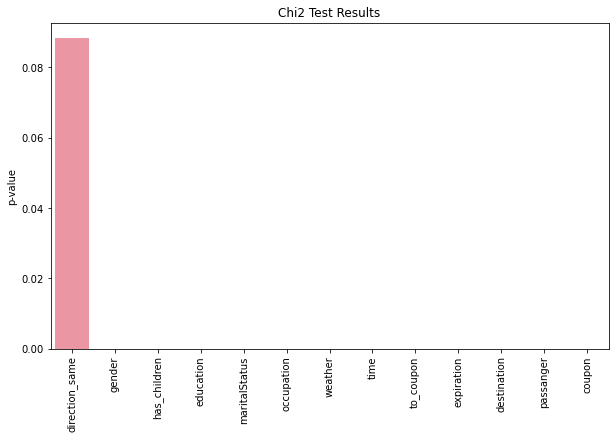

In [53]:
# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the dictionary into a dataframe
chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['p-value'])

# Sort the dataframe by p-value
chi2_results_df.sort_values(by='p-value', ascending=False, inplace=True)

# Plot the p-values
plt.figure(figsize=(10, 6))
sns.barplot(x=chi2_results_df.index, y='p-value', data=chi2_results_df)
plt.xticks(rotation=90)
plt.title('Chi2 Test Results')
plt.ylabel('p-value')
plt.show()

In [55]:
from scipy.stats import rankdata

def rank_biserial_correlation(df, ordinal_var, binary_var='Y'):
    # Rank the ordinal variable
    ranked = rankdata(df[ordinal_var])
    
    # Compute means of the ranked data for each group in the binary variable
    rank_mean_0 = ranked[df[binary_var] == 0].mean()
    rank_mean_1 = ranked[df[binary_var] == 1].mean()
    
    # Compute Rank Biserial correlation
    n_0 = (df[binary_var] == 0).sum()
    n_1 = (df[binary_var] == 1).sum()
    
    r = (rank_mean_1 - rank_mean_0) / (n_0 + n_1)
    
    return r

# Applying the function to the specified ordinal columns
ordinal_col = ['temperature', 'age', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
for col in ordinal_col:
    r = rank_biserial_correlation(df_correlation, col)
    print(f"Rank Biserial correlation between {col} and Y: {r:.4f}")


Rank Biserial correlation between temperature and Y: 0.0329
Rank Biserial correlation between age and Y: -0.0351
Rank Biserial correlation between income and Y: -0.0161
Rank Biserial correlation between Bar and Y: 0.0421
Rank Biserial correlation between CoffeeHouse and Y: 0.0691
Rank Biserial correlation between CarryAway and Y: 0.0200
Rank Biserial correlation between RestaurantLessThan20 and Y: 0.0243
Rank Biserial correlation between Restaurant20To50 and Y: 0.0381


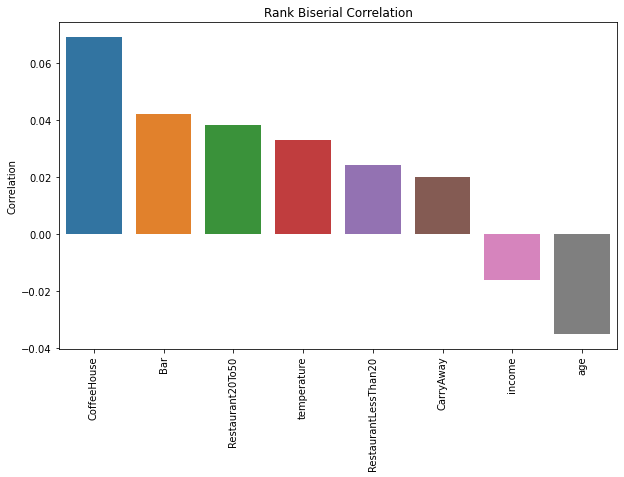

In [56]:
# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns

# Empty dictionary to store the Rank Biserial correlation values
rank_biserial_results = {}

# Applying the function to the specified ordinal columns
ordinal_col = ['temperature', 'age', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
for col in ordinal_col:
    r = rank_biserial_correlation(df_correlation, col)
    rank_biserial_results[col] = r

# Convert the dictionary into a dataframe
rank_biserial_results_df = pd.DataFrame.from_dict(rank_biserial_results, orient='index', columns=['Rank Biserial Correlation'])

# Sort the dataframe by Rank Biserial correlation
rank_biserial_results_df.sort_values(by='Rank Biserial Correlation', ascending=False, inplace=True)

# Plot the Rank Biserial correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=rank_biserial_results_df.index, y='Rank Biserial Correlation', data=rank_biserial_results_df)
plt.xticks(rotation=90)
plt.title('Rank Biserial Correlation')
plt.ylabel('Correlation')
plt.show()

